In [205]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

<Axes: title={'center': 'Train C'}, xlabel='time'>

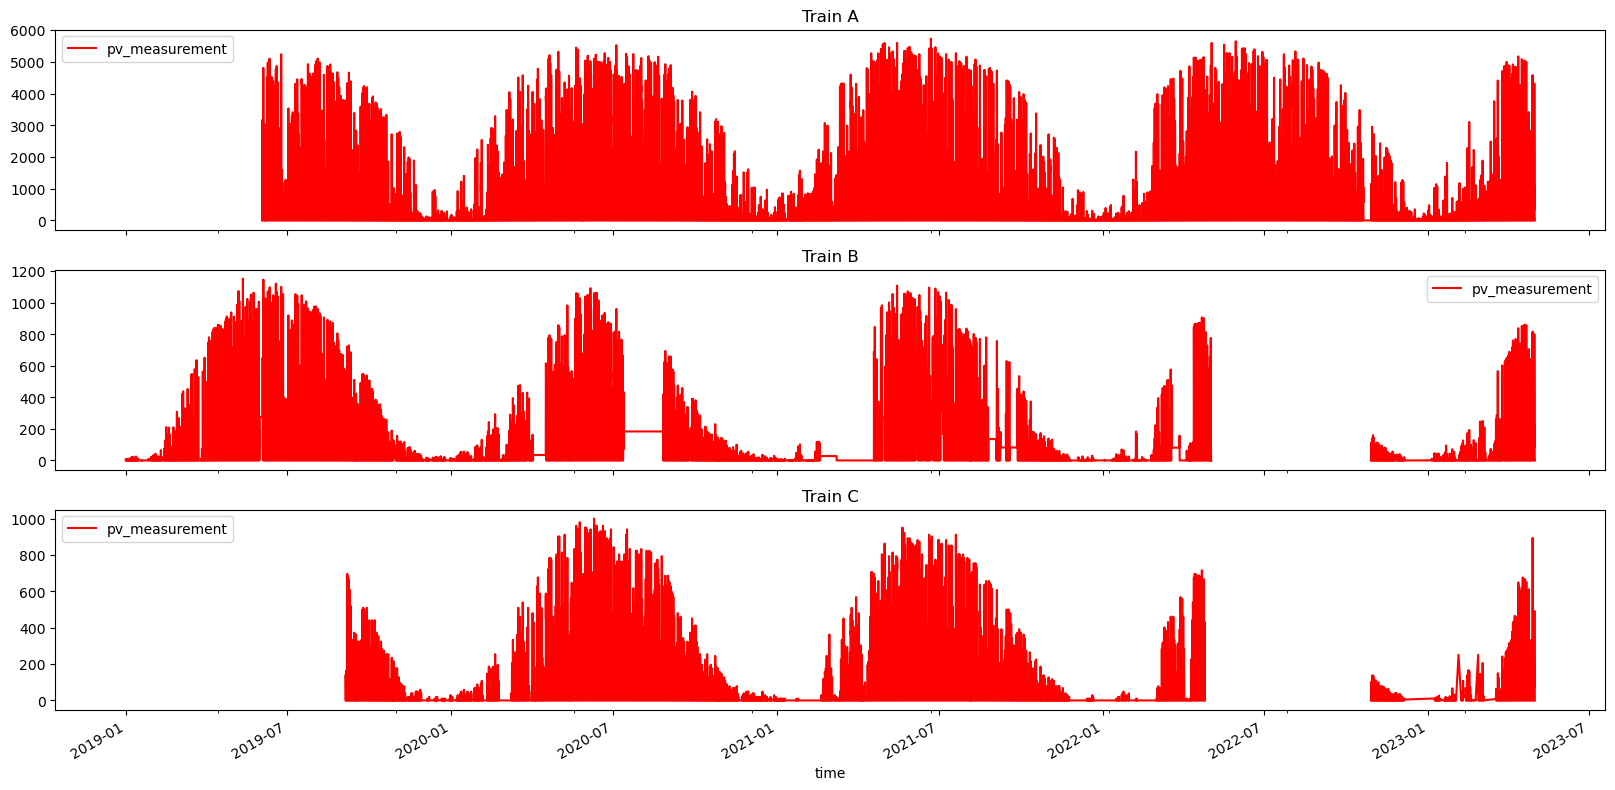

In [3]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
train_a[['time', "pv_measurement"]].set_index('time').plot(ax=axs[0], title='Train A', color='red')
train_b[['time', "pv_measurement"]].set_index('time').plot(ax=axs[1], title='Train B', color='red')
train_c[['time', "pv_measurement"]].set_index('time').plot(ax=axs[2], title='Train C', color='red')

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [5]:
X_train_observed_b = pd.read_parquet('dataset/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('dataset/C/X_train_observed.parquet')

X_train_estimated_b = pd.read_parquet('dataset/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('dataset/C/X_train_estimated.parquet')

X_test_estimated_a = pd.read_parquet('dataset/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('dataset/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('dataset/C/X_test_estimated.parquet')

In [6]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [286]:
X_train_observed_a = pd.read_parquet('dataset/A/X_train_observed.parquet') #Train_x
X_train_estimated_a = pd.read_parquet('dataset/A/X_train_estimated.parquet') # Val_x

In [287]:
train_x = quartersToHours(X_train_observed_a)
val_x = quartersToHours(X_train_estimated_a)
val_x = val_x.drop(["date_calc"], axis=1)

In [288]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

    

train_data, val_data = join_data_and_labels(train_x, val_x, train_a)

In [289]:
# Remove wind speed as it is incorporated into the wind components
wind_speed = train_data.pop('wind_speed_10m:ms')
wind_speed = val_data.pop('wind_speed_10m:ms')


constanst_columns = []
# Remove constants
for key, value in train_data.std().items():
    if value == 0.0:
        constanst_columns.append(key)
        
for key in constanst_columns:
    if val_data.std()[key] != 0.0:
        constanst_columns.remove(key)
        
            
for key in constanst_columns:
    train_data = train_data.drop([key], axis=1)
    val_data = val_data.drop([key], axis=1)
    

#Turn date into sin and cos
day = 24*60*60
year = (365.2425)*day
month = year / 12.0

date_time = pd.to_datetime(train_data.pop('date'), format='%Y-%m.%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

train_data['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
train_data['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
train_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
train_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


date_time = pd.to_datetime(val_data.pop('date'), format='%Y-%m.%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

val_data['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
val_data['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
val_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
val_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# Fill 0 for NaNs
train_data = train_data.fillna(0)
val_data = val_data.fillna(0)

# Isday should be a binary value
train_data["is_day:idx"] = [round(train_data["is_day:idx"][i]) for i in range(len(train_data))]
val_data["is_day:idx"] = [round(val_data["is_day:idx"][i]) for i in range(len(val_data))]

In [272]:
val_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
absolute_humidity_2m:gm3,4394.0,4.092438,1.510517,1.000000,3.000000,3.900000,5.050000,8.750000e+00
air_density_2m:kgm3,4394.0,1.281746,0.030034,1.212000,1.261750,1.279500,1.300500,1.373250e+00
ceiling_height_agl:m,4394.0,2583.859131,2587.205322,0.000000,66.300001,1911.737488,4151.762573,1.229490e+04
clear_sky_energy_1h:J,4394.0,237126.328125,515875.781250,0.000000,0.000000,0.000000,136779.250000,2.540279e+06
clear_sky_rad:W,4394.0,65.868156,143.746780,0.000000,0.000000,0.000000,37.818750,7.098250e+02
cloud_base_agl:m,4394.0,1406.163086,1692.531860,0.000000,363.625008,812.362488,1771.849976,1.081370e+04
dew_or_rime:idx,4394.0,0.008990,0.211707,-1.000000,0.000000,0.000000,0.000000,1.000000e+00
dew_point_2m:K,4394.0,270.222351,5.214528,254.699997,266.850006,270.399994,273.899994,2.821000e+02
diffuse_rad:W,4394.0,22.836435,45.606945,0.000000,0.000000,0.000000,22.275001,2.941000e+02
diffuse_rad_1h:J,4394.0,82210.851562,162106.796875,0.000000,0.000000,0.000000,80090.277344,1.030832e+06


In [290]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, label_columns):

        self.train_df = train_df
        self.val_df = val_df
        #self.test_df = test_df

        self.label_columns = label_columns

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        
        self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
        
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
              data=data,
              targets=None,
              sequence_length=self.total_window_size,
              sequence_stride=1,
              shuffle=True,
              batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
    def plot(self, model=None, plot_col='pv_measurement', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [291]:
single_step_window  = WindowGenerator(input_width=1, label_width=1, shift=1,train_df=train_data, val_df=val_data,
                     label_columns=['pv_measurement'])

for example_inputs, example_labels in single_step_window .train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    
single_step_window

Inputs shape (batch, time, features): (32, 1, 46)
Labels shape (batch, time, features): (32, 1, 1)


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['pv_measurement']

Inputs shape (batch, time, features): (32, 24, 46)
Labels shape (batch, time, features): (32, 24, 1)


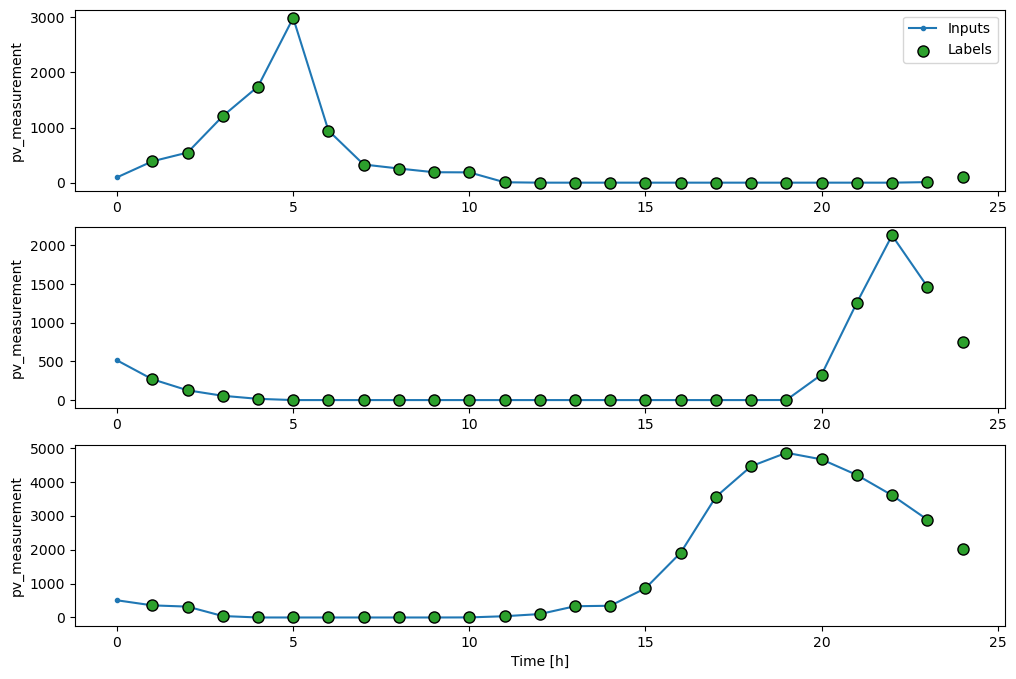

In [292]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1,train_df=train_data, val_df=val_data,
                     label_columns=['pv_measurement'])

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    
wide_window 

wide_window.plot()

138/138 - 1s - loss: 110057.0938 - mean_absolute_error: 133.6369 - 892ms/epoch - 6ms/step


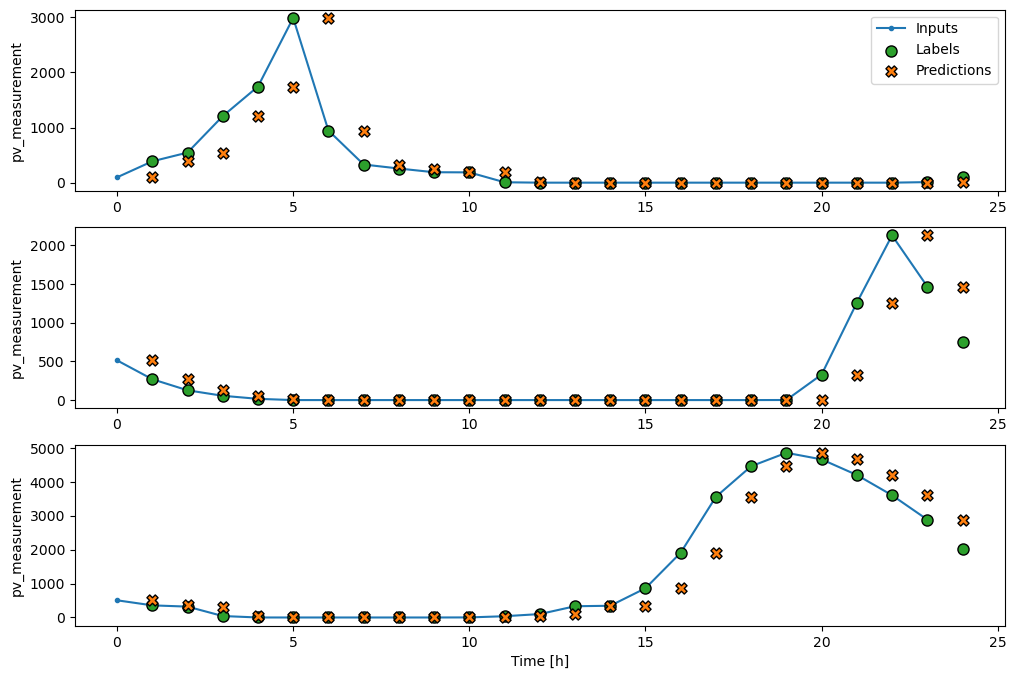

In [293]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]
    
baseline = Baseline(label_index=single_step_window.column_indices['pv_measurement'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, verbose=2)

wide_window.plot(baseline)

In [294]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [295]:
linear = tf.keras.Sequential([
    tf.keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False),
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

history = compile_and_fit(linear, wide_window)

val_performance['Linear'] = linear.evaluate(wide_window.val)
#performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Input shape: (32, 24, 46)
Output shape: (32, 24, 1)
Epoch 1/20
927/927 [==============================] - 10s 9ms/step - loss: 9196666880.0000 - mean_absolute_error: 40627.4023 - val_loss: 164896064.0000 - val_mean_absolute_error: 8082.8438
Epoch 2/20
927/927 [==============================] - 8s 8ms/step - loss: 204795440.0000 - mean_absolute_error: 8605.1250 - val_loss: 83382664.0000 - val_mean_absolute_error: 5892.0825
Epoch 3/20
927/927 [==============================] - 8s 8ms/step - loss: 75671880.0000 - mean_absolute_error: 5537.5381 - val_loss: 26485230.0000 - val_mean_absolute_error: 3453.1255
Epoch 4/20
927/927 [==============================] - 8s 8ms/step - loss: 17584624.0000 - mean_absolute_error: 2809.6882 - val_loss: 5633708.5000 - val_mean_absolute_error: 1783.0884
Epoch 5/20
927/927 [==============================] - 8s 8ms/step - loss: 3226017.0000 - mean_absolute_error: 1379.8842 - val_loss: 1817174.2500 - val_mean_absolute_error: 1113.7147
Epoch 6/20
927/927 [=====

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

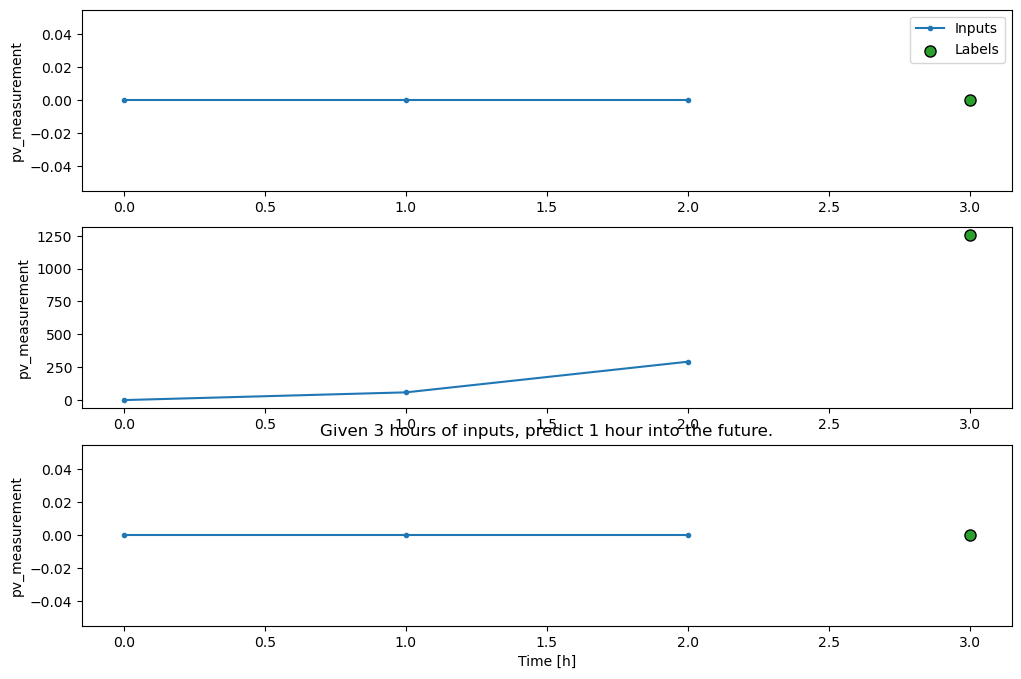

In [296]:
CONV_WIDTH = 3
conv_window = WindowGenerator(input_width=CONV_WIDTH, label_width=1, shift=1,train_df=train_data, val_df=val_data,
                     label_columns=['pv_measurement'])

conv_window

conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [297]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)

Input shape: (32, 3, 46)
Output shape: (32, 1, 1)
Epoch 1/20
927/927 [==============================] - 10s 10ms/step - loss: 258327008.0000 - mean_absolute_error: 3768.3479 - val_loss: 5159153.5000 - val_mean_absolute_error: 1112.6372
Epoch 2/20
927/927 [==============================] - 9s 9ms/step - loss: 5813603.0000 - mean_absolute_error: 1294.9249 - val_loss: 1680689.6250 - val_mean_absolute_error: 637.2714
Epoch 3/20
927/927 [==============================] - 9s 9ms/step - loss: 3851289.7500 - mean_absolute_error: 1064.4834 - val_loss: 1551079.5000 - val_mean_absolute_error: 598.8860
Epoch 4/20
927/927 [==============================] - 9s 9ms/step - loss: 3174628.5000 - mean_absolute_error: 978.3799 - val_loss: 1296601.8750 - val_mean_absolute_error: 539.5261
Epoch 5/20
927/927 [==============================] - 9s 9ms/step - loss: 3993325.0000 - mean_absolute_error: 1016.6697 - val_loss: 944459.4375 - val_mean_absolute_error: 508.2990
Epoch 6/20
927/927 [======================

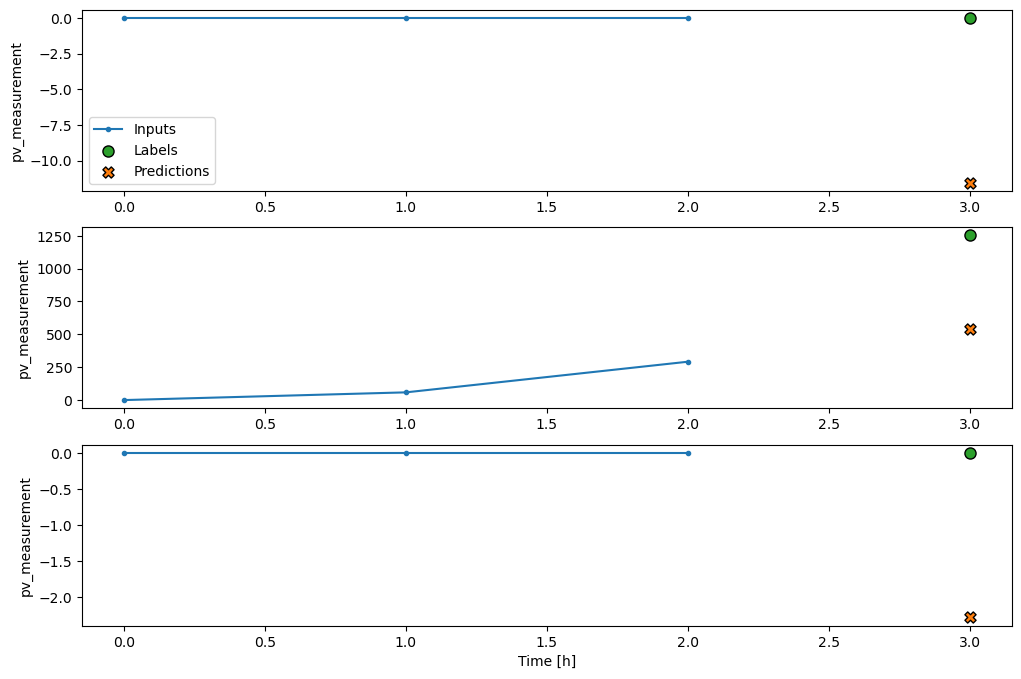

In [298]:
conv_window.plot(multi_step_dense)

In [299]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1,train_df=train_data, val_df=val_data,
                     label_columns=['pv_measurement'])

wide_conv_window

conv_model = tf.keras.Sequential([
    tf.keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False),

    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

history = compile_and_fit(conv_model, wide_conv_window)

val_performance['Conv'] = conv_model.evaluate(wide_conv_window.val)

Wide conv window
Input shape: (32, 26, 46)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)
Epoch 1/20
927/927 [==============================] - 14s 13ms/step - loss: 6675108.0000 - mean_absolute_error: 944.9621 - val_loss: 316368.0312 - val_mean_absolute_error: 283.4891
Epoch 2/20
927/927 [==============================] - 11s 12ms/step - loss: 638206.8750 - mean_absolute_error: 444.9188 - val_loss: 208347.7969 - val_mean_absolute_error: 224.5882
Epoch 3/20
927/927 [==============================] - 11s 12ms/step - loss: 411998.2812 - mean_absolute_error: 361.1490 - val_loss: 155978.6719 - val_mean_absolute_error: 208.5635
Epoch 4/20
927/927 [==============================] - 11s 12ms/step - loss: 370865.2812 - mean_absolute_error: 330.6580 - val_loss: 549656.0625 - val_mean_absolute_error: 343.9211
Epoch 5/20
927/927 [==============================] - 11s 12ms/step - loss: 338113.1562 - mean_absolute_error: 303.4855 - val_loss: 141200.0469 - val_mean_absolute_error: 184.0502
Epoc

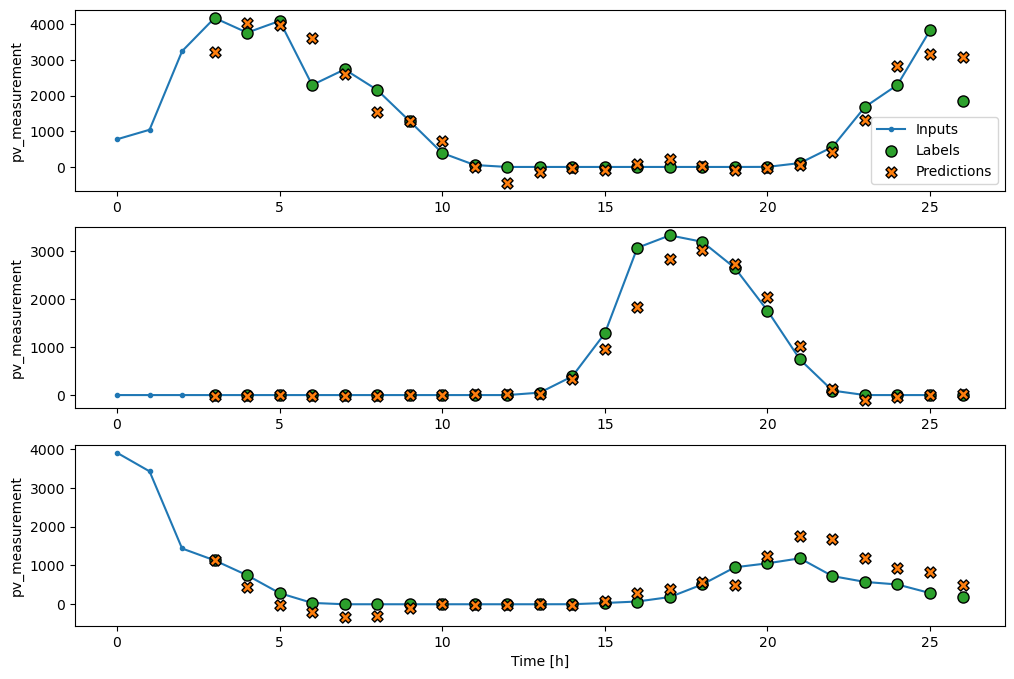

In [300]:
wide_conv_window.plot(conv_model)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

Input shape: (32, 24, 46)
Output shape: (32, 24, 1)
Epoch 1/20
927/927 [==============================] - 40s 34ms/step - loss: 1874181.5000 - mean_absolute_error: 673.2321 - val_loss: 899037.3125 - val_mean_absolute_error: 342.1192
Epoch 2/20
927/927 [==============================] - 30s 33ms/step - loss: 1851349.5000 - mean_absolute_error: 669.7464 - val_loss: 889161.8125 - val_mean_absolute_error: 340.9709
Epoch 3/20
927/927 [==============================] - 31s 33ms/step - loss: 1832549.0000 - mean_absolute_error: 666.0696 - val_loss: 880035.5625 - val_mean_absolute_error: 343.5661
Epoch 4/20
927/927 [==============================] - 31s 33ms/step - loss: 1810497.7500 - mean_absolute_error: 661.3792 - val_loss: 867211.0000 - val_mean_absolute_error: 338.7117
Epoch 5/20
 33/927 [>.............................] - ETA: 27s - loss: 1803128.0000 - mean_absolute_error: 658.5491

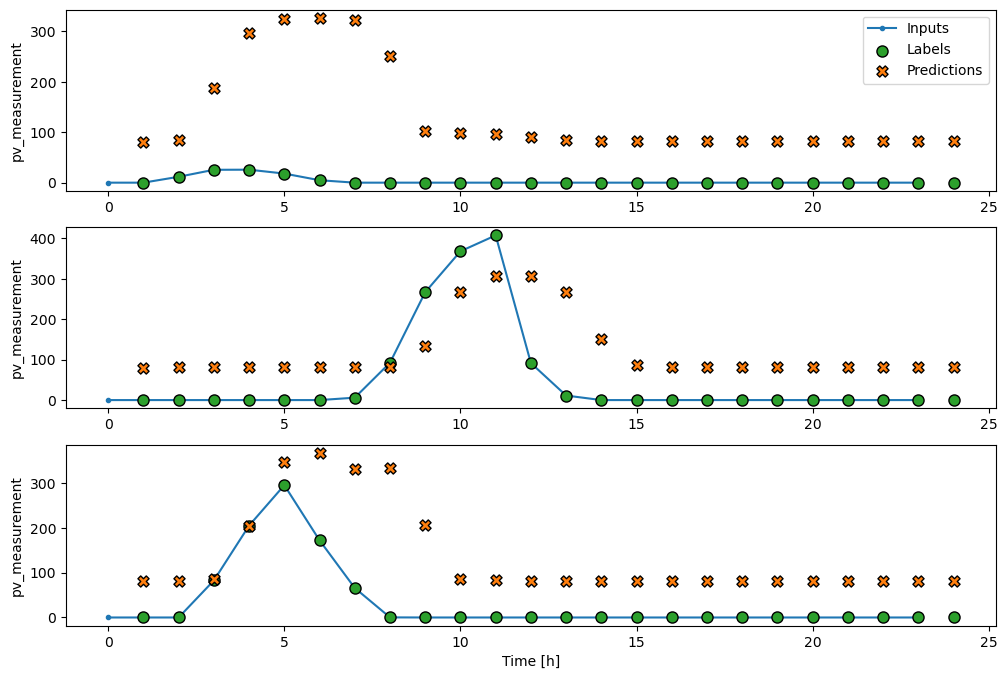

In [196]:
wide_window.plot(lstm_model)

In [8]:
test = pd.read_csv('test.csv')
test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [10]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [11]:
# Example, let the predictions be random values
test['prediction'] = np.random.rand(len(test))
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)